# Description
This notebook can be used analyze sensor data provided that the data is correctly prepared.

The following variables are calculated:

The following plots can be found:

# Contents
- User provided settings
- Data import and method declaration
- Data exploration and computation of variables
- Plots

# How to use
## Step 1 - Prepare data
Prepare your data by creating two excel files, one holding the data and one describing the variables
## Step 2 - Run scripts
Run each cell in the script using the "Cell/Run Cells" button on the top. You can choose to run all cells at once clicking "Run All". 

# Settings
User provided input options:

- Start date ('yyyy-mm-dd HH:MM:SS')
- Stop date ('yyyy-mm-dd HH:MM:SS')
- Median sample rate, in minutes. If other than '1', data is median sampled.
- File locations for data file (data_file) and observation and variable description file (obsvardef_file)

In [2]:
start_date = '2017-01-01 00:00:00'
stop_date = '2018-04-01 00:00:00'
median_sample_rate = '5'
exo_file = 'C:/Users/joel0921/OneDrive - IVL Svenska Miljöinstitutet AB/DigiDrick II/DigiDrickExo/Summary.xlsx'
vv_file = 'C:/Users/joel0921/OneDrive - IVL Svenska Miljöinstitutet AB/DigiDrick II/DigiDrickExo/Trollhättan_2017.xlsx'
obsvardef_file = 'C:/Users/joel0921/OneDrive - IVL Svenska Miljöinstitutet AB/DigiDrick II/DigiDrickExo/ObsVarDef.xlsx'

##### Python package import

In [3]:
import numpy as np
import pandas as pd
import json
import glob
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib
import requests
from matplotlib.legend import Legend
from matplotlib.lines import Line2D
from sklearn import linear_model
import sklearn.cross_decomposition as skcd
# 


##### Method declarations

In [4]:
def exclude_limits(input_data, obsvardef):
    output_data = input_data
    for col in output_data.columns:
        
        min_limit = obsvardef['Min limit'].loc[obsvardef['Beskrivning']==col].values[0]
        max_limit = obsvardef['Max limit'].loc[obsvardef['Beskrivning']==col].values[0]
        if ~np.isnan(min_limit):
            output_data[col].loc[output_data[col] < min_limit] = np.nan
        if max_limit is not None:
            output_data[col].loc[output_data[col] > max_limit] = np.nan
        
    return output_data


def identify_outlier(data, data_column, median_window=24, nbr_of_stds=3, outlier_indicator=True, outlier_bw_offset=0, outlier_fw_offset=0):


    if isinstance(data,
                  pd.DataFrame):  # If the input is a DataFrame it is treated specially to be able to return a DataFrame
        df = True
        dataframe = data
        # data = data.values  # Convert DataFrame to numpy array
    else:
        df = False
        data = pd.DataFrame(data)

    data['raw_log'] = np.log(data[data_column])  # Natural log , 
    data['daily_mean_raw_log'] = data['raw_log'].rolling(median_window).median() #.reindex(data.index, method='ffill')
    data['daily_stdev_raw_log'] = data['raw_log'].rolling(median_window).std() #.reindex(data.index, method='ffill')
    data['log_deviation'] = (data['raw_log'] - data['daily_mean_raw_log']).abs() / data['daily_stdev_raw_log']
    data['t+1diff'] = data[data_column].diff(periods=1).abs()
    data['t-1diff'] = data[data_column].diff(periods=-1).abs()
    data['diff_minmax'] = data[['t-1diff', 't+1diff']].max(axis=1) / data[['t-1diff', 't+1diff']].min(axis=1)
    
    outlier_col = data_column + '_outliers'
    data[outlier_col] = False
    data[outlier_col].loc[((data['log_deviation'] > nbr_of_stds) & (data['diff_minmax'] < 2)) | (data['log_deviation'] > nbr_of_stds + 1)] = outlier_indicator
    data.drop(['log_deviation', 'diff_minmax', 't-1diff', 't+1diff',
              'daily_stdev_raw_log', 'daily_mean_raw_log',
              'raw_log'], axis=1, inplace=True)
    outliers = data[outlier_col]
    for b_ix in range(outlier_bw_offset):
        outliers += outliers.shift(-1*b_ix)
    for f_ix in range(outlier_fw_offset):
        outliers += outliers.shift(f_ix)

    data[outlier_col] = outliers > 0
    
    return data


##### Import exo-sensor data

In [5]:
xl = pd.ExcelFile(exo_file)
sheet_names = xl.sheet_names
sensor_data = pd.DataFrame()
count = 0 
for sheet in sheet_names:
    print('Importing: ' + sheet)
    df = pd.read_excel(exo_file, sheet_name=sheet, index_col=0, header=0)  # Import data file to pandas Dataframe
    dt = [datetime.datetime.utcfromtimestamp(int(ts)).strftime('%Y-%m-%d %H:%M:%S') for ts in df.index]
    df.index = pd.to_datetime(dt)
    df.columns = df.columns + '_' + sheet
    if count == 0:
        sensor_data = df
    else:
        sensor_data = pd.merge(sensor_data, df, left_index=True, right_index=True, how='inner')
    count += 1
    
sensor_data.drop_duplicates()    
print('Done')

Importing: Gaddeback
Importing: Surte
Importing: Sodra Nol
Importing: Larjeholm
Done


##### Import site data

In [6]:
xl = pd.ExcelFile(vv_file)
sheet_names = xl.sheet_names
vv_data = pd.DataFrame()
for sheet in sheet_names:
    print('Importing: ' + sheet)
    df = pd.read_excel(vv_file, sheet_name=sheet)  # Import data file to pandas Dataframe
    df.index = df['Time']
    df.drop(['Time'], axis=1)
    vv_data = pd.concat([vv_data, df])
    
vv_data.drop_duplicates()    
print('Done')

Importing: Blad1
Done


##### Pre-process data (median filter and exclusion)

In [7]:
obsvardef_data = pd.read_excel(obsvardef_file)

vv = vv_data.resample(median_sample_rate + 'T').median()
exo = sensor_data.resample(median_sample_rate + 'T').median()
joined_data = pd.merge(vv, exo, left_index=True, right_index=True, how='inner')

data_limits_applied = exclude_limits(joined_data, obsvardef_data)

### Overview plot

In [8]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, Layout
import cufflinks as cf
import plotly.offline as py
cf.go_offline()

start_date = widgets.DatePicker(description='Start', disabled=False, value=pd.to_datetime('2017-01-01'))
display(start_date)
stop_date = widgets.DatePicker(description='Stop', disabled=False, value=pd.to_datetime('2018-01-01'))
display(stop_date)

median_slider = widgets.IntSlider(min=5, max=60, step=1, value=10, description='Median filter [min]')
display(median_slider)

y_list = widgets.SelectMultiple(
    options=list(data_limits_applied.select_dtypes('number').columns),
    value=[data_limits_applied.select_dtypes('number').columns[0]],
    description='Input columns',
    disabled=False)

@interact
def update_plot(y=y_list):
    
    df = data_limits_applied.resample(str(median_slider.value) + 'T').median()
    df = df.loc[start_date.value:stop_date.value]
    plot_df = df[list(y)]
    display(plot_df.iplot())

DatePicker(value=Timestamp('2017-01-01 00:00:00'), description='Start')

DatePicker(value=Timestamp('2018-01-01 00:00:00'), description='Stop')

IntSlider(value=10, description='Median filter [min]', max=60, min=5)

interactive(children=(SelectMultiple(description='Input columns', index=(0,), options=('Färg råvatten ISCAN', …

### Identify outliers
Select which signal to use for outlier detection

In [10]:
window_slider = widgets.IntSlider(min=10, max=60, step=1, value=24, description='Median filter window [time steps]')
display(window_slider)

@interact
def update_plot(outlier_signal=list(data_limits_applied.columns)):
    
    data = data_limits_applied.copy()
    data = identify_outlier(data, outlier_signal, window_slider.value, nbr_of_stds=3)
    
    plot_df = pd.DataFrame()
    plot_df[outlier_signal] = data[outlier_signal]
    outliers = data[outlier_signal + '_outliers']
    
    plot_df['Outliers Removed'] = data[outlier_signal].loc[~outliers]
    data_limits_applied[outlier_signal + '_OutliersRemoved'] = data[outlier_signal]
    data_limits_applied[outlier_signal + '_OutliersRemoved'].loc[outliers] = np.nan
    
    display(plot_df.iplot())
    

IntSlider(value=24, description='Median filter window [time steps]', max=60, min=10)

interactive(children=(Dropdown(description='outlier_signal', options=('Färg råvatten ISCAN', 'TOC råvatten ISC…

##### Find cross-correlations
Cross correlations can be used to determine the time-lag between signals

In [11]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))


start_date = data_limits_applied.index[0]
end_date = data_limits_applied.index[-1]
duration = end_date - start_date
duration_months = round(duration.days/30)

datelist = pd.date_range(start_date, periods=duration_months+1, freq='1M').tolist()
points = 72
t_vec = []

@interact
def update_plot(y_1=list(data_limits_applied.columns), y_2=list(data_limits_applied.columns)):
    plt.figure(figsize=(20, 10))
    for day_ix in range(len(datelist)-1):
        mask = (data_limits_applied.index > datelist[day_ix]) & (data_limits_applied.index <= datelist[day_ix + 1])
        datay = data_limits_applied[y_1].loc[mask]
        datax = data_limits_applied[y_2].loc[mask]
        xcov = [crosscorr(datax, datay, lag=i) for i in range(-1*points, points)]
        plt.plot(range(-1*points, points), xcov, label='Period: ' + str(datelist[day_ix]) + ' - ' + str(datelist[day_ix + 1]) )
        t_vec.append(xcov.index(max(xcov)))
    
    plt.xlabel('Time shift [ each step is ' + median_sample_rate + ' minutes]')
    plt.ylabel('CrossCorrelation')
    plt.grid(True, which='major')
    plt.grid(True, which='minor', linestyle='--')
    plt.legend()




interactive(children=(Dropdown(description='y_1', options=('Färg råvatten ISCAN', 'TOC råvatten ISCAN', 'Turbi…

## Calculate early warning capability

##### Method definition

In [12]:
from scipy.signal import find_peaks
from matplotlib.lines import Line2D

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def filter_out_anomalies(random_data):
    
    
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(random_data)
    random_data_mean = np.mean(random_data)
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    
    # Never allow data points below 0
    if lower_limit < 0:
        lower_limit = 0
    
    temp = random_data[random_data > lower_limit]
    out = temp[temp < upper_limit]
    #print("Removed values over " + str(upper_limit) + " and values under " + str(lower_limit))
    return out


def is_value_in_interval(val, range1, range2):
    return range1 <= val <= range2


def measure_overlap(data1,data2):
    latest_start = max(data1[0], data2[0])
    earliest_end = min(data1[1], data2[1])
    delta = earliest_end-latest_start + 1
    overlap = max(0,delta)
    return overlap


def peak_finder(data1, data2, resample_frequency, smoothing_factor = 300, peak_limit = 7, peak_width = 120, plot=False):
    print("%%%%%%%%%%%%%%% PARAMETERS %%%%%%%%%%%%%%%")
    print("Finding peaks with the following settings:")
    print("Smoothing windows size: " + str(smoothing_factor))
    print("Resample frequency: " + str(resample_frequency))
    print("Minimum peak limit: " + str(peak_limit))
    print("Minimum peak width: " + str(peak_width))
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
      
    
    # Array of data2 values over peak limit
    #data2_over_pl_all_points = (data2 > peak_limit).values
    
    # Filter out anomalies
    data1_col = data1.name
    #data1 = identify_outlier(data1, data1_col, 100, nbr_of_stds=3)
    #data1 = data1[data1_col].loc[~data1[data1_col + '_outliers']]
    
    data2_col = data2.name
    #data2 = identify_outlier(data2, data2_col, 100, nbr_of_stds=3)
    #data2 = data2[data2_col].loc[~data2[data2_col + '_outliers']]
    
    # Store times. TODO: Plot against these values!
    data1_time = data1.index
    data2_time = data2.index
    data1_start_stop = [data1_time[0], data1_time[-1]]
    data2_start_stop = [data2_time[0], data2_time[-1]]
    
    # Smooth (moving average with smoothing_factor = window size)
    data1 = smooth(data1, smoothing_factor)
    data2 = smooth(data2, smoothing_factor)
    
    # Find peaks
    data1_peaks, data1_peak_properties = find_peaks(data1, width = peak_width, height = peak_limit)
    data2_peaks, data2_peak_properties = find_peaks(data2, width = peak_width, height = peak_limit)
    
    # convert time frequency to integer
    time_resolution = resample_frequency # minutes
    
    # Intervals of each peak in data2
    data2_peak_starts = data2_peaks - data2_peak_properties['widths']/2
    data2_peak_ends = data2_peaks + data2_peak_properties['widths']/2
    p2_intervals = list(zip(data2_peak_starts, data2_peak_ends))

    # Intervals of each peak in data1, with one hour cutoff in the beginning of data1 peaks
    p1_intervals = list(zip(data1_peaks - data1_peak_properties['widths']/2 + 60/time_resolution, 
                               data1_peaks + data1_peak_properties['widths']/2))# - 60/time_resolution))

    p2_p1_matches = list()
    for interval in p2_intervals: # Each data2 peak interval
        temp_p2_start = int(interval[0])
        temp_p2_end = int(interval[1])

        # Check if start OR end point of p2 interval is within p1 interval
        true_false_tuple_list = [(is_value_in_interval(temp_p2_start, p1_interval[0], p1_interval[1]), 
          is_value_in_interval(temp_p2_end, p1_interval[0], p1_interval[1])) for p1_interval in p1_intervals]

        p2_peaks_in_p1 = [a or b for (a,b) in true_false_tuple_list]
        p2_p1_matches.append(p2_peaks_in_p1)
    
    # Check which peaks were found and store the results in peak properties
    all_matches = np.array([], dtype=bool)
    for match in p2_p1_matches:
        all_matches = np.append(all_matches, bool(np.sum(match)))
    data2_peak_properties['predicted'] = all_matches    
    
    # Array of data2 values over peak limit
    dd_2 = np.zeros(len(data2),dtype=bool)
    for interval in p2_intervals:
        start = int(interval[0])
        stop = int(interval[1])
        dd_2[start:stop] = True
    
    data2_over_pl_all_points = dd_2
    
    # Calculate ratio of predicted peaks based on data1 that are found
    dd = np.zeros(len(data2_over_pl_all_points),dtype=bool)
    for interval in p1_intervals:
        start = int(interval[0])
        stop = int(interval[1])
        dd[start:stop] = True
    
    true_positives = np.zeros(len(data2_over_pl_all_points),dtype=bool)
    false_positives = np.zeros(len(data2_over_pl_all_points),dtype=bool)
    false_negatives = np.zeros(len(data2_over_pl_all_points),dtype=bool)    
    for idx in range(len(dd)):
        true_positives[idx] = all([dd[idx],data2_over_pl_all_points[idx]])
        false_positives[idx] =  dd[idx] and not data2_over_pl_all_points[idx]
        false_negatives[idx] = data2_over_pl_all_points[idx] and not dd[idx]
    pred_ratio = np.sum(true_positives)/np.sum(data2_over_pl_all_points)
    false_positive_rate = np.sum(false_positives)/np.sum(data2_over_pl_all_points)
    false_negative_rate = np.sum(false_negatives)/np.sum(data2_over_pl_all_points)
    
    # Measure overlap of intervals
    total_overlap = 0
    for p1_interval in p1_intervals:
        for p2_interval in p2_intervals:
            total_overlap += measure_overlap(p1_interval,p2_interval)
    overlap_p2_fraction = total_overlap/np.sum(data2_peak_properties['widths'])
    overlap_p1_fraction = total_overlap/np.sum(data1_peak_properties['widths'])

    # Plot
    if plot:
        # Plot the data, as it is filtered above.
        start = pd.Timestamp(data1_time[0])
        end = pd.Timestamp(data1_time[-1])
        t = np.linspace(start.value, end.value, len(data1))
        t = pd.to_datetime(t)
        start_d2 = pd.Timestamp(data2_time[0])
        end_d2 = pd.Timestamp(data2_time[-1])
        t2 = np.linspace(start_d2.value, end_d2.value, len(data2))
        t2 = pd.to_datetime(t2)        
        plt.figure(figsize=(20,10))
        plt.plot(t, data1, label = data1_col)
        plt.plot(t2, data2, label = data2_col)
        plt.title("Data 1 & 2 with marker sizes being relative to width of the peaks",fontsize=20)
        
        # Plot markers at peaks with marker sizes relative to width of peaks.
        data1_marker_sizes = data1_peak_properties['widths']/max(data1_peak_properties['widths'])*50
        data2_marker_sizes = data2_peak_properties['widths']/max(data2_peak_properties['widths'])*50
        for idx, point in enumerate(data1_peaks):
            plt.plot(t[point], data1[point], '.',markersize=data1_marker_sizes[idx],color="C0")
        for idx, point in enumerate(data2_peaks):
            plt.plot(t2[point], data2[point], '.',markersize=data2_marker_sizes[idx],color="C1")
        plt.legend(fontsize=15,loc=1)
        
        # Plot only markers in time order with size being relative to width of peaks
        plt.figure(figsize=(20,5))
        for idx, point in enumerate(data1_peaks):
            plt.plot(t[point], 1, '.',markersize=data1_marker_sizes[idx],color="C0")
        for idx, point in enumerate(data2_peaks):
            plt.plot(t2[point], 0, '.',markersize=data2_marker_sizes[idx],color="C1")
        
        # Plot true positives green and true negatives red
        plot_linspace = np.linspace(start.value,end.value,len(data2_over_pl_all_points))    
        plot_linspace = pd.to_datetime(plot_linspace)
        plt.plot(plot_linspace[data2_over_pl_all_points], np.repeat(-1,len(plot_linspace))[data2_over_pl_all_points],'r',marker='.',linestyle = 'None',markersize=13)
        plt.plot(plot_linspace[true_positives], np.repeat(-1,len(plot_linspace))[true_positives],'g',marker='.',linestyle = 'None',markersize=13)
        plt.title("Peaks ranged in time order with marker size being relative to the width of the peaks",fontsize=20)
        custom_lines = [Line2D([0], [0], color='C0', marker=".",linestyle = 'None'),
                        Line2D([0], [0], color='C1', marker='.',linestyle = 'None'),
                       Line2D([0], [0], color='g', marker='.',linestyle = 'None'),
                       Line2D([0], [0], color='r', marker='.',linestyle = 'None')]
        plt.legend(custom_lines, [data1_col, data2_col, 'Values over peak limit in ' + data2_col + ' and predicted',
                                  'Values over peak limit in ' + data2_col + ' but not predicted'],fontsize=15,loc=1)
        plt.ylim([-2,4])
        plt.yticks([])
    
    ratio_number_of_peaks = np.sum(data2_peak_properties['predicted'])/len(data2_peaks)
    
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% RESULTS %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print("Ratio of values over " + str(peak_limit) + " in " + data2_col + " found as peaks in " + data1_col + " (True positives): " + str(round(pred_ratio,2)))
    print("Ratio of values over " + str(peak_limit) + " in " + data2_col + " not found as peaks in " + data1_col + " (False negatives): " + str(round(false_negative_rate,2)))
    print("Ratio of values under " + str(peak_limit) + " in " + data2_col + " found as peaks in " + data1_col + " (False positives): " + str(round(false_positive_rate,2)))
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    
    return [data1_peaks,data1_peak_properties, data2_peaks, data2_peak_properties]

##### Early warning evaluation
- Signal 1: the earlier signal to be evaluated
- Signal 2: the later signal used as "truth"

In [14]:
from IPython.display import clear_output
%matplotlib inline

start_date = widgets.DatePicker(description='Start', disabled=False, value=pd.to_datetime('2017-01-01'))
display(start_date)
stop_date = widgets.DatePicker(description='Stop', disabled=False, value=pd.to_datetime('2018-01-01'))
display(stop_date)

median_slider = widgets.IntSlider(min=5, max=60, step=1, value=10, description='Median filter [min]')
display(median_slider)

peak_width_slider = widgets.IntSlider(min=10, max=200, step=10, value=50, description='Peak width [min]')
display(peak_width_slider)

peak_limit_slider = widgets.IntSlider(min=5, max=50, step=1, value=7, description='Peak limit')
display(peak_limit_slider)


@interact
def update_plot(Signal_1=list(data_limits_applied.columns), Signal_2=list(data_limits_applied.columns)):
    
    
    df = data_limits_applied.resample(str(median_slider.value) + 'T').median()
    df = df.loc[start_date.value:stop_date.value]
    peak_finder(df[Signal_1], df[Signal_2], median_slider.value, plot = True, smoothing_factor = 50, peak_limit = peak_limit_slider.value, peak_width = peak_width_slider.value)
    


DatePicker(value=Timestamp('2017-01-01 00:00:00'), description='Start')

DatePicker(value=Timestamp('2018-01-01 00:00:00'), description='Stop')

IntSlider(value=10, description='Median filter [min]', max=60, min=5)

IntSlider(value=50, description='Peak width [min]', max=200, min=10, step=10)

IntSlider(value=7, description='Peak limit', max=50, min=5)

interactive(children=(Dropdown(description='Signal_1', options=('Färg råvatten ISCAN', 'TOC råvatten ISCAN', '…

<IPython.core.display.Javascript object>


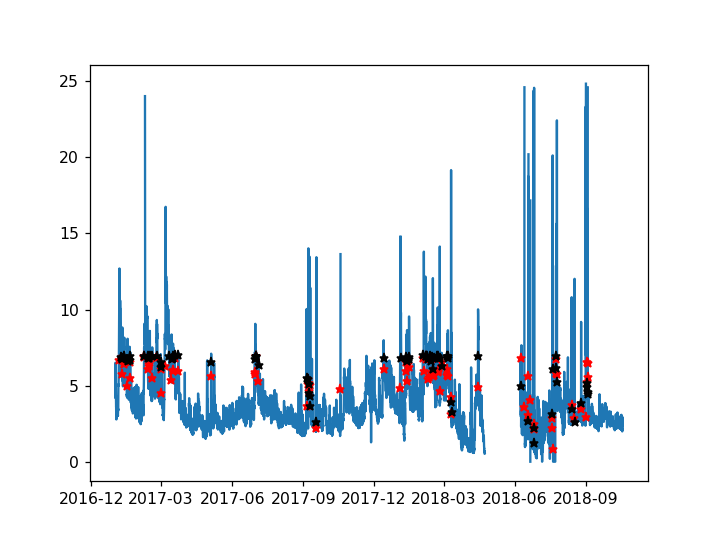

<IPython.core.display.Javascript object>


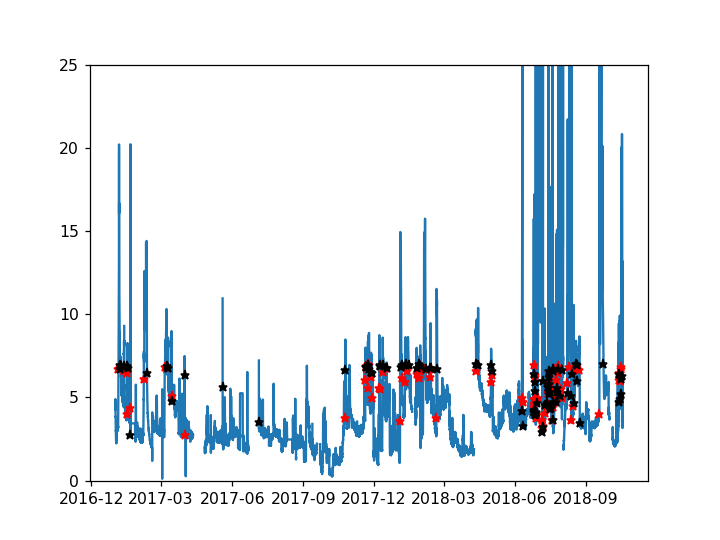

<IPython.core.display.Javascript object>


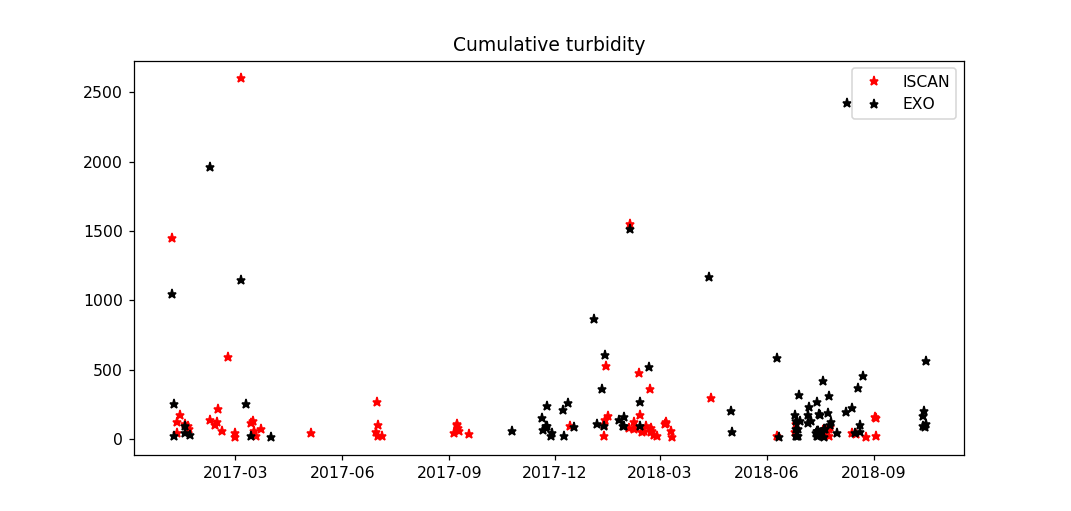

<IPython.core.display.Javascript object>


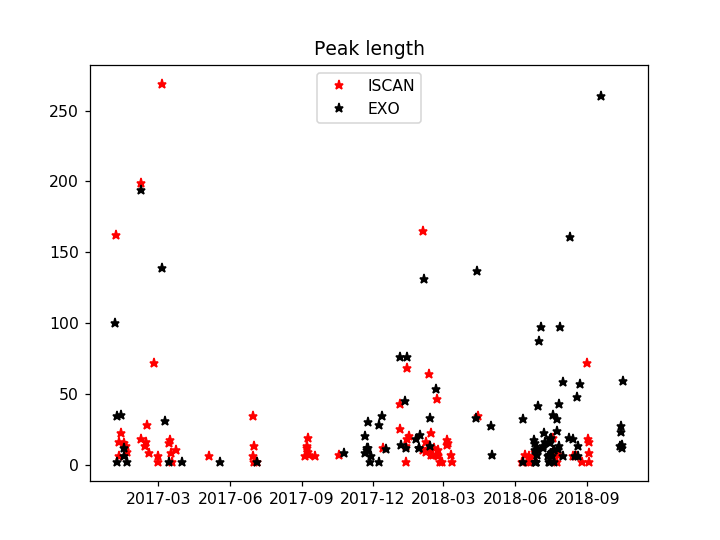

In [47]:
%matplotlib notebook

joined_data_inner['Turbidity_FNU'].loc[joined_data_inner['Turbidity_FNU'] < 0 ] = np.nan
joined_data_inner['Turbidity_FNU'].loc[joined_data_inner['Turbidity_FNU'] > 100] = np.nan

rv_limit = 7
exo_limit = 7
min_length = 4
rv_mask = joined_data_inner['Turbiditetet råvatten ISCAN'] > rv_limit
exo_mask = joined_data_inner['Turbidity_FNU'] > exo_limit

### ISCAN ###
rv_mask = np.array(rv_mask) * 1
rv_mask[np.isnan(rv_mask)] = 1

for ix in range(min_length, len(rv_mask)):
    if (rv_mask[ix]==1) & (sum(rv_mask[ix-min_length:ix])>=1):
        rv_mask[ix-min_length:ix] = 1

cumsum = np.cumsum(rv_mask)
cumsum_diff = np.diff(cumsum)

start_ix_rv = []
start_time_rv = []
stop_ix_rv = []
stop_time_rv = []

for ix in range(1, len(cumsum_diff)):
    if (cumsum_diff[ix-1]==0) & (cumsum_diff[ix]==1):  
        start_ix_rv.append(ix)
        start_time_rv.append(joined_data_inner.index[ix])
    elif (cumsum_diff[ix-1]==1) & (cumsum_diff[ix]==0):
        stop_ix_rv.append(ix+1)
        stop_time_rv.append(joined_data_inner.index[ix+1])

if len(start_time_rv) > len(stop_time_rv):
    start_time_rv = start_time_rv[:-1]
    start_ix_rv = start_ix_rv[:-1]

cum_turb_rv = []
peak_length_rv = []
for ix in range(len(stop_ix_rv)):
    peak_length_rv.append(stop_ix_rv[ix]-start_ix_rv[ix])
    cum_turb_rv.append(sum(joined_data_inner['Turbiditetet råvatten ISCAN'].loc[start_time_rv[ix]:stop_time_rv[ix]]))

        
plt.figure()
plt.plot(joined_data_inner['Turbiditetet råvatten ISCAN'])
plt.plot(joined_data_inner['Turbiditetet råvatten ISCAN'].loc[start_time_rv], 'r*')
plt.plot(joined_data_inner['Turbiditetet råvatten ISCAN'].loc[stop_time_rv], 'k*')
plt.show()

### EXO ###
exo_mask = np.array(exo_mask) * 1
exo_mask[np.isnan(exo_mask)] = 1

for ix in range(min_length, len(exo_mask)):
    if (exo_mask[ix]==1) & (sum(exo_mask[ix-min_length:ix])>=1):
        exo_mask[ix-min_length:ix] = 1

cumsum = np.cumsum(exo_mask)
cumsum_diff = np.diff(cumsum)

start_ix_exo = []
start_time_exo = []
stop_ix_exo = []
stop_time_exo = []

for ix in range(1, len(cumsum_diff)):
    if (cumsum_diff[ix-1]==0) & (cumsum_diff[ix]==1):  
        start_ix_exo.append(ix)
        start_time_exo.append(joined_data_inner.index[ix])
    elif (cumsum_diff[ix-1]==1) & (cumsum_diff[ix]==0):
        stop_ix_exo.append(ix+1)
        stop_time_exo.append(joined_data_inner.index[ix+1])

if len(start_time_exo) > len(stop_time_exo):
    start_time_exo = start_time_exo[:-1]
    start_ix_exo = start_ix_exo[:-1]
        
cum_turb_exo = []
peak_length_exo = []
for ix in range(len(stop_ix_exo)):
    peak_length_exo.append(stop_ix_exo[ix]-start_ix_exo[ix])
    cum_turb_exo.append(sum(joined_data_inner['Turbidity_FNU'].loc[start_time_exo[ix]:stop_time_exo[ix]]))


        
        
plt.figure()
plt.plot(joined_data_inner['Turbidity_FNU'])
plt.plot(joined_data_inner['Turbidity_FNU'].loc[start_time_exo], 'r*')
plt.plot(joined_data_inner['Turbidity_FNU'].loc[stop_time_exo], 'k*')
plt.ylim([0, 25])
plt.show()


plt.figure()
plt.title('Cumulative turbidity')
plt.plot(start_time_rv, cum_turb_rv, 'r*')
plt.plot(start_time_exo, cum_turb_exo, 'k*')
plt.legend(['ISCAN', 'EXO'])
plt.show()


plt.figure()
plt.title('Peak length')
plt.plot(start_time_rv, peak_length_rv,'r*')
plt.plot(start_time_exo, peak_length_exo,'k*')
plt.legend(['ISCAN', 'EXO'])
plt.show()

[1, 1]
